In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import plotly.express as px
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib
%matplotlib inline

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#reading in all datasets
road_network = gpd.read_file('road_network_processed.geojson')
#road_network = gpd.read_file('ontario_road_network_processed.geojson')
bikelanes = gpd.read_file('cycling_network.geojson')
collisions = gpd.read_file('collisions_processed.geojson')
intersections = gpd.read_file('centreline_intersections_processed.geojson')
ksi = pd.read_csv('ksi_processed.csv')
lanes = gpd.read_file('lanes_processed.geojson')
pedestrian_crossings = gpd.read_file('pedestrian_crossover_processed.geojson')
sensitive_zones = gpd.read_file('sensitive_areas_processed_final.geojson')
speed_enforcement = gpd.read_file('speed_enforcement_processed.geojson')
speed_limits = gpd.read_file('speed_limits_processed.geojson')
traffic_calming = gpd.read_file('traffic_calming_processed.geojson')
traffic_cameras = gpd.read_file('traffic_cameras_processed.geojson')
traffic_volumes = pd.read_csv('traffic_volumes_processed_2.csv')

In [3]:
print(road_network.crs)
print(bikelanes.crs)
print(lanes.crs)
print(sensitive_zones.crs)
print(collisions.crs)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326


CRS = EPSG:3857 (Distance in metres)
CRS = EPSG:4326 (Distance in lat/long degrees)

In [4]:
"""""
#setting all dataset to same crs
road_network = road_network.to_crs('EPSG:3857')
bikelanes = bikelanes.to_crs('EPSG:3857')
collisions = collisions.to_crs('EPSG:3857') #messes up geometry column
intersections = intersections.to_crs('EPSG:3857')
ksi = ksi.to_crs('EPSG:3857')
lanes = lanes.to_crs('EPSG:3857')
pedestrian_crossings = pedestrian_crossings.to_crs('EPSG:3857')
sensitive_zones = sensitive_zones.to_crs('EPSG:3857') #messes up geometry column
speed_enforcement = speed_enforcement.to_crs('EPSG:3857')
speed_limits = speed_limits.to_crs('EPSG:3857')
traffic_calming = traffic_calming.to_crs('EPSG:3857') 
traffic_cameras = traffic_cameras.to_crs('EPSG:3857') #messes up geometry column
traffic_volumes = traffic_volumes.to_crs('EPSG:3857')
"""

'""\n#setting all dataset to same crs\nroad_network = road_network.to_crs(\'EPSG:3857\')\nbikelanes = bikelanes.to_crs(\'EPSG:3857\')\ncollisions = collisions.to_crs(\'EPSG:3857\') #messes up geometry column\nintersections = intersections.to_crs(\'EPSG:3857\')\nksi = ksi.to_crs(\'EPSG:3857\')\nlanes = lanes.to_crs(\'EPSG:3857\')\npedestrian_crossings = pedestrian_crossings.to_crs(\'EPSG:3857\')\nsensitive_zones = sensitive_zones.to_crs(\'EPSG:3857\') #messes up geometry column\nspeed_enforcement = speed_enforcement.to_crs(\'EPSG:3857\')\nspeed_limits = speed_limits.to_crs(\'EPSG:3857\')\ntraffic_calming = traffic_calming.to_crs(\'EPSG:3857\') \ntraffic_cameras = traffic_cameras.to_crs(\'EPSG:3857\') #messes up geometry column\ntraffic_volumes = traffic_volumes.to_crs(\'EPSG:3857\')\n'

In [5]:
print(road_network.crs)
print(bikelanes.crs)
print(lanes.crs)
print(sensitive_zones.crs)
print(collisions.crs)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326
EPSG:4326


# Main Dataset - Road Network

In [6]:
road_network.head()

,centreline_id,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry
0,914600,Morrison Street,St,201500,Local,"MULTILINESTRING ((-79.50875 43.59744, -79.5098..."
1,914601,Twelfth Street,St,201500,Local,"MULTILINESTRING ((-79.50987 43.59720, -79.5103..."
2,7862398,Thirteenth Street,St,201500,Local,"MULTILINESTRING ((-79.51087 43.59697, -79.5113..."
3,914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191..."
4,6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202..."


In [7]:
#setting centreline_id id as index
#road_network = road_network.set_index('centreline_id')
road_network = road_network.set_index('centreline_id')

In [8]:
road_network.head(2)

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry
centreline_id,,,,,
914600,Morrison Street,St,201500,Local,"MULTILINESTRING ((-79.50875 43.59744, -79.5098..."
914601,Twelfth Street,St,201500,Local,"MULTILINESTRING ((-79.50987 43.59720, -79.5103..."


# Joining Bikelanes

In [9]:
#bikelanes data processing
bikelanes.columns = [s.strip().lower() for s in bikelanes.columns]
#drop unneeded columns
bikelanes = bikelanes.drop(columns=['objectid','segment_id','upgraded','pre_amalgamation','roadclass','cnpclass','surface','owner','dir_loworder','sepa_loworder','sepb_loworder','orig_loworder_infra','dir_highorder','sepa_highorder','sepb_highorder','orig_highorder','bylawed','editor','last_edit_date','upgrade_description','converted'])
#rename id column
bikelanes = bikelanes.rename(columns={'_id':'id'})
#set id column as index
bikelanes = bikelanes.set_index('id')
#adding a bikelane_present column
bikelanes['bikelane_present'] = "Yes"

In [10]:
bikelanes.head()

,installed,street_name,from_street,to_street,infra_loworder,infra_highorder,geometry,bikelane_present
id,,,,,,,,
1,2001,Kilbarry Rd,Highbourne Rd,Oriole Pkwy,Sharrows - Wayfinding,Sharrows - Wayfinding,"MULTILINESTRING ((-79.40351 43.69526, -79.4030...",Yes
2,2001,Martin Goodman / Waterfront Trl,Lake Shore Blvd W,Martin Goodman Trl Branch,Multi-Use Trail,Multi-Use Trail,"MULTILINESTRING ((-79.40364 43.63499, -79.4035...",Yes
3,2001,Gatineau Hydro Corridor Trl,Givendale Rd,Kennedy Rd,Multi-Use Trail,Multi-Use Trail,"MULTILINESTRING ((-79.27522 43.74158, -79.2751...",Yes
4,2001,G Ross Lord Park Trl,Dufferin St,G Ross Lord Park Trl Branch,Multi-Use Trail,Multi-Use Trail,"MULTILINESTRING ((-79.46772 43.77208, -79.4675...",Yes
5,2001,Etobicoke Creek Trl,Etobicoke Creek Trl Branch,Forty Third St,Multi-Use Trail - Entrance,Multi-Use Trail - Entrance,"MULTILINESTRING ((-79.54812 43.59027, -79.5480...",Yes


In [ ]:
#joining road network and bikelanes using a radius search of 0.0003 degrees = 30 metres.
#essentially road segments that have a bikelane present within 30 metres
join_1 = road_network.sjoin_nearest(bikelanes,how='left',max_distance=0.0003,lsuffix='road_network',rsuffix='bikelanes')

In [12]:
road_network.shape

(45184, 5)

In [13]:
bikelanes.shape

(1323, 8)

In [14]:
join_1.shape

(47562, 13)

In [15]:
join_1.bikelane_present.fillna("No",inplace=True)

In [16]:
join_1 = join_1.drop(columns=['index_bikelanes','installed','street_name','from_street','to_street','infra_loworder','infra_highorder'])

In [17]:
join_1.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present
centreline_id,,,,,,
914600,Morrison Street,St,201500,Local,"MULTILINESTRING ((-79.50875 43.59744, -79.5098...",No
914601,Twelfth Street,St,201500,Local,"MULTILINESTRING ((-79.50987 43.59720, -79.5103...",No
7862398,Thirteenth Street,St,201500,Local,"MULTILINESTRING ((-79.51087 43.59697, -79.5113...",Yes
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No


<AxesSubplot:>

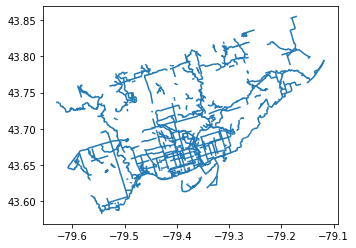

In [18]:
bikelanes.plot()

<AxesSubplot:>

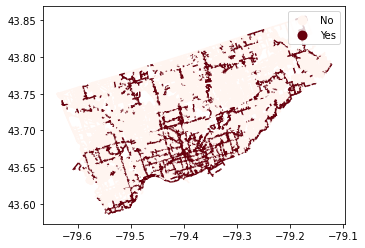

In [19]:
#color plot by bikelane_present: red if bikelane is present, blue if bikelane is not present
join_1.plot(column='bikelane_present',legend=True,cmap='Reds')

# Joining Lanes 

In [20]:
lanes.head()

,road_name,road_class,number_of_lanes,geometry
0,F G GARDINER XY W,City Expressway,3,"LINESTRING (-79.54521 43.61462, -79.54518 43.6..."
1,CENTENNIAL PARK BLVD,Collector,4,"LINESTRING (-79.59005 43.64550, -79.59019 43.6..."
2,BELVEDERE BLVD,Local,2,"LINESTRING (-79.51511 43.65010, -79.51669 43.6..."
3,LAKE SHORE BLVD W,Major Arterial,4,"LINESTRING (-79.53400 43.59435, -79.53560 43.5..."
4,F G GARDINER XY E,City Expressway,3,"LINESTRING (-79.54509 43.61445, -79.54501 43.6..."


In [21]:
join_2 = join_1.sjoin(lanes,how='inner',lsuffix='road_network',rsuffix='lanes')

In [22]:
join_2.shape

(36643, 10)

In [23]:
lanes.shape

(49451, 4)

In [24]:
join_1.shape

(47562, 6)

In [25]:
join_2.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,index_lanes,road_name,road_class,number_of_lanes
centreline_id,,,,,,,,,,
914600,Morrison Street,St,201500,Local,"MULTILINESTRING ((-79.50875 43.59744, -79.5098...",No,19025,TWELFTH ST,Local,2
914601,Twelfth Street,St,201500,Local,"MULTILINESTRING ((-79.50987 43.59720, -79.5103...",No,18480,JACKSON RD,Local,2
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,1164,TWENTIETH ST,Local,2
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,1158,TWENTY FIRST ST,Local,2
20145557,Crescent Road,Rd,201400,Collector,"MULTILINESTRING ((-79.38071 43.67833, -79.3804...",No,45133,MOUNT PLEASANT RD,Major Arterial,4


In [26]:
#dropping index_lanes column
join_2 = join_2.drop(columns=['index_lanes'])

# Joining Pedestrian Crossings

Note: Pedestrian Crossing is joined on a radius search. Pedestrian Crossing is "Yes" for a road segment if a crossing is present within 30 metres of that road segment.

Consider changing this to a lower or higher number.

In [27]:
pedestrian_crossings.head()

,id,pedestrian_crossover_main_street,pedestrian_crossover_side1_street,pedestrian_crossover_pedestrian_crossover,geometry
0,1,BATHURST ST,COLLEGE ST,Yes,MULTIPOINT (-79.40820 43.65771)
1,2,BATHURST ST,SCADDING CRT,Yes,MULTIPOINT (-79.40560 43.65127)
2,3,ANGLESEY BLVD,HARTFIELD RD,Yes,MULTIPOINT (-79.52851 43.66460)
3,4,BAYVIEW AVE,PARKHURST BLVD,Yes,MULTIPOINT (-79.37634 43.70870)
4,5,ANNETTE ST,DURIE ST,Yes,MULTIPOINT (-79.48257 43.65949)


In [28]:
#set id as index
pedestrian_crossings = pedestrian_crossings.set_index('id')

In [29]:
join_3 = join_2.sjoin_nearest(pedestrian_crossings,how='left',lsuffix='road_network',rsuffix='pedestrian_crossings',max_distance=0.0003)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [30]:
pedestrian_crossings.shape

(492, 4)

In [31]:
join_2.shape

(36643, 9)

In [32]:
join_3.shape

(36643, 13)

In [33]:
#filling in values for road segments where pedestrian crossings are not present
join_3.pedestrian_crossover_pedestrian_crossover.fillna('No',inplace=True)

In [34]:
#looking at the distribution of Yes/No values
#note there are 1371 "Yes" values, which is much higher than the actual number of pedestrian crossings
join_3.pedestrian_crossover_pedestrian_crossover.value_counts()

No     35450
Yes     1193
Name: pedestrian_crossover_pedestrian_crossover, dtype: int64

In [35]:
#dropping unneeded columns 
join_3 = join_3.drop(columns=['index_pedestrian_crossings','pedestrian_crossover_main_street','pedestrian_crossover_side1_street'])

<AxesSubplot:>

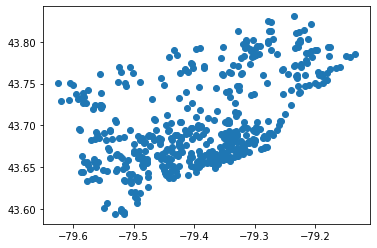

In [36]:
pedestrian_crossings.plot()

<AxesSubplot:>

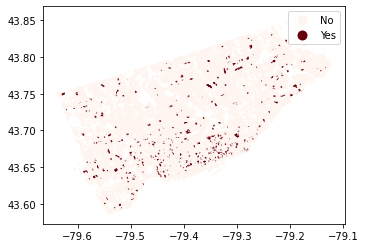

In [37]:
join_3.plot(column='pedestrian_crossover_pedestrian_crossover',legend=True,cmap='Reds')

# Joining Traffic Calming

In [38]:
traffic_calming.head()

,traffic_calmingstreet,traffic_calmingintersection,traffic_calmingspeed_hump,traffic_calmingtraffic_island,traffic_calmingspeed_cushion,geometry
0,Oakridge Drive,Brimley Rd,8,0,0,"LINESTRING (-79.24360 43.72610, -79.24305 43.7..."
1,Atlas Avenue,Gloucester Grove,2,0,0,"LINESTRING (-79.43774 43.69668, -79.43815 43.6..."
2,Balliol Street,Mt. Pleasant Road,2,0,0,"LINESTRING (-79.38631 43.69940, -79.38182 43.7..."
3,Balmoral Avenue,Avenue Road,6,0,0,"LINESTRING (-79.39316 43.68589, -79.39378 43.6..."
4,Bartlett Avenue North,Geary Avenue,6,0,0,"LINESTRING (-79.43679 43.66998, -79.43697 43.6..."


In [39]:
join_4 = join_3.sjoin(traffic_calming,how='left',lsuffix='road_network',rsuffix='traffic_calming')

In [40]:
join_4.shape

(36729, 16)

<AxesSubplot:>

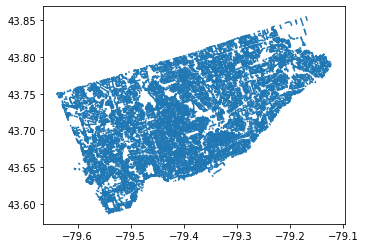

In [41]:
join_4.plot()

<AxesSubplot:>

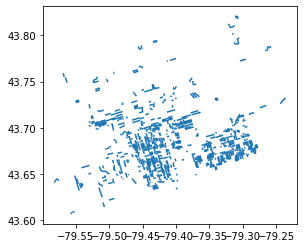

In [42]:
traffic_calming.plot()

<AxesSubplot:>

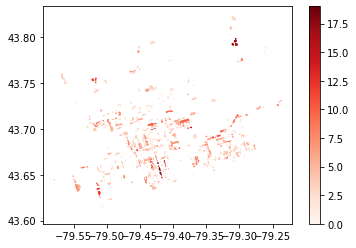

In [43]:
join_4.plot(column='traffic_calmingspeed_hump',legend=True,cmap='Reds')

In [44]:
join_4 = join_4.drop(columns=['index_traffic_calming','traffic_calmingstreet','traffic_calmingintersection'])

In [45]:
traffic_calming.traffic_calmingtraffic_island.value_counts()

0    856
1      3
6      2
2      1
3      1
5      1
Name: traffic_calmingtraffic_island, dtype: int64

In [46]:
#join_4[['traffic_calmingspeed_hump','traffic_calmingtraffic_island','traffic_calmingspeed_cushion']].fillna('0',inplace=True)
join_4['traffic_calmingspeed_hump'].fillna(0,inplace=True)
join_4['traffic_calmingtraffic_island'].fillna(0,inplace=True)
join_4['traffic_calmingspeed_cushion'].fillna(0,inplace=True)

In [47]:
join_4.tail()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name,road_class,number_of_lanes,pedestrian_crossover_pedestrian_crossover,traffic_calmingspeed_hump,traffic_calmingtraffic_island,traffic_calmingspeed_cushion
centreline_id,,,,,,,,,,,,,
20112825,Ray Avenue,Ave,201400,Collector,"MULTILINESTRING ((-79.49420 43.68867, -79.4941...",No,LN E WESTON S BARTONVILLE,Laneway,1,No,0.0,0.0,0.0
8310,Weston Road,Rd,201300,Minor Arterial,"MULTILINESTRING ((-79.49393 43.68857, -79.4942...",No,RAY AVE,Collector,0,No,0.0,0.0,0.0
8189,Ray Avenue,Ave,201400,Collector,"MULTILINESTRING ((-79.49348 43.68984, -79.4930...",No,RAY AVE,Collector,2,No,0.0,0.0,0.0
3130598,The Kingsway,None,201400,Collector,"MULTILINESTRING ((-79.51960 43.66270, -79.5201...",No,BEXHILL CRT,Local,2,No,0.0,0.0,0.0
30140554,St Stevens Court,Crt,201500,Local,"MULTILINESTRING ((-79.52010 43.66434, -79.5200...",No,ST STEVENS CRT,Local,2,No,0.0,0.0,0.0


# Joining Speed Enforcement

Speed Enforcement uses a radius search of 30 metres. Consider changing this radius.

In [48]:
speed_enforcement.head()

,location_code,speed_enforcement_speed_enforcement_automatic_speed_enforcement,geometry
0,A298,Yes,MULTIPOINT (-79.56022 43.73667)
1,A318,Yes,MULTIPOINT (-79.56942 43.71741)
2,A319,Yes,MULTIPOINT (-79.59493 43.74885)
3,A252,Yes,MULTIPOINT (-79.55458 43.63745)
4,A253,Yes,MULTIPOINT (-79.51767 43.68003)


In [49]:
#data processing

#setting location_code as index
speed_enforcement.set_index('location_code',inplace=True)

#renaming speed_enforcement = "Yes" column
speed_enforcement = speed_enforcement.rename(columns={'speed_enforcement_speed_enforcement_automatic_speed_enforcement	':'speed_enforcement_present'})

In [50]:
#joining dataframes, with radius search range of 30m
join_5 = join_4.sjoin_nearest(speed_enforcement,how='left',max_distance=0.0003,lsuffix='road_network',rsuffix='speed_enforcement')

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [51]:
#fill na values for speed_enforcement_present = "No"
join_5.speed_enforcement_speed_enforcement_automatic_speed_enforcement.fillna('No',inplace=True)

In [52]:
#checking values for speed enforcement
join_5.speed_enforcement_speed_enforcement_automatic_speed_enforcement.value_counts()

No     36567
Yes      163
Name: speed_enforcement_speed_enforcement_automatic_speed_enforcement, dtype: int64

In [53]:
#renaming columns
join_5.rename(columns={'speed_enforcement_speed_enforcement_automatic_speed_enforcement':'speed_enforcement_present'},inplace=True)

In [54]:
#dropping columns
#join_5 = join_5.drop(columns=['index_right'])

In [55]:
join_5.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name,road_class,number_of_lanes,pedestrian_crossover_pedestrian_crossover,traffic_calmingspeed_hump,traffic_calmingtraffic_island,traffic_calmingspeed_cushion,index_speed_enforcement,speed_enforcement_present
centreline_id,,,,,,,,,,,,,,,
914600,Morrison Street,St,201500,Local,"MULTILINESTRING ((-79.50875 43.59744, -79.5098...",No,TWELFTH ST,Local,2,No,0.0,0.0,0.0,NaN,No
914601,Twelfth Street,St,201500,Local,"MULTILINESTRING ((-79.50987 43.59720, -79.5103...",No,JACKSON RD,Local,2,No,0.0,0.0,0.0,NaN,No
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,0.0,0.0,0.0,NaN,No
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,TWENTY FIRST ST,Local,2,No,0.0,0.0,0.0,NaN,No
20145557,Crescent Road,Rd,201400,Collector,"MULTILINESTRING ((-79.38071 43.67833, -79.3804...",No,MOUNT PLEASANT RD,Major Arterial,4,Yes,0.0,0.0,0.0,NaN,No


<AxesSubplot:>

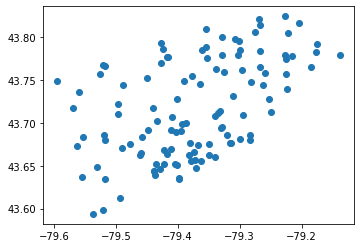

In [56]:
speed_enforcement.plot()

<AxesSubplot:>

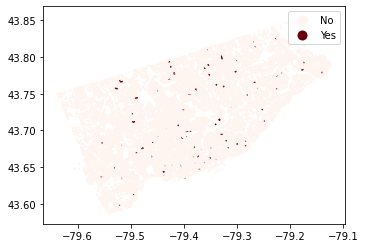

In [57]:
join_5.plot(column='speed_enforcement_present',legend=True,cmap='Reds')

# Joining Traffic Volumes

Note: Only 36 rows show up in the merged dataset. This will have to be investigated and the join done again.

In [58]:
traffic_volumes = pd.read_csv('traffic_volumes_processed_2.csv')

In [59]:
traffic_volumes.head(2)

,centreline_id,location,lat,lng,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks
0,10158856,VICTORIA PARK AVE AT 1420 VICTORIA PARK AVE,43.722082,-79.301578,37,25,8543,137,8481,99.274260,0.292637,0.433103,1.603652
1,103344,ZOO RD AT ZOO MEADOWVALE RD N RAMP & MEADOWVAL...,43.818250,-79.174415,2,5,275,16,268,97.454545,1.818182,0.727273,5.818182


In [60]:
type(traffic_volumes)

pandas.core.frame.DataFrame

In [61]:
traffic_volumes['geometry'] = gpd.points_from_xy(traffic_volumes['lng'],traffic_volumes['lat'],crs='EPSG:4326')

In [62]:
#converting traffic volumes to geodataframe
traffic_volumes = gpd.GeoDataFrame(traffic_volumes,geometry=traffic_volumes['geometry'])

In [63]:
traffic_volumes.head(2)

,centreline_id,location,lat,lng,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,geometry
0,10158856,VICTORIA PARK AVE AT 1420 VICTORIA PARK AVE,43.722082,-79.301578,37,25,8543,137,8481,99.274260,0.292637,0.433103,1.603652,POINT (-79.30158 43.72208)
1,103344,ZOO RD AT ZOO MEADOWVALE RD N RAMP & MEADOWVAL...,43.818250,-79.174415,2,5,275,16,268,97.454545,1.818182,0.727273,5.818182,POINT (-79.17441 43.81825)


In [64]:
#removing columns
traffic_volumes = traffic_volumes.drop(columns=['lat','lng'])
#set centreline_id as index
traffic_volumes.set_index('centreline_id',inplace=True)

In [65]:
#spatial join on traffic volumes using a radius search of 0.001 degrees = 100 metres radius
join_6 = join_5.sjoin_nearest(traffic_volumes,how='inner',max_distance=0.001,lsuffix='road_network',rsuffix='traffic_volumes')

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [66]:
join_6.shape

(10872, 26)

In [67]:
traffic_volumes.shape

(2360, 11)

In [68]:
join_6.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name,road_class,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,location,cyclists_count,pedestrians_count,total_count,trucks_count,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks
centreline_id,,,,,,,,,,,,,,,,,,,,,
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,...,LAKE SHORE BLVD W ATTWENTIETH ST,10,792,8375,122,7573,90.423881,9.456716,0.119403,1.456716
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,TWENTY FIRST ST,Local,2,No,...,LAKE SHORE BLVD W ATTWENTIETH ST,10,792,8375,122,7573,90.423881,9.456716,0.119403,1.456716
914588,Twentieth Street,St,201500,Local,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",Yes,BIRMINGHAM ST,Collector,2,Yes,...,LAKE SHORE BLVD W ATTWENTIETH ST,10,792,8375,122,7573,90.423881,9.456716,0.119403,1.456716
9950476,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.54180 43.59258, -79.5421...",Yes,BROWNS LI LAKESHORE W RAMP,Major Arterial Ramp,2,No,...,BROWNS LINE AT LAKE SHORE BLVD (PX 242),13,961,13315,338,12341,92.684942,7.217424,0.097634,2.538490
3135620,Brown's Line,Line,201200,Major Arterial,"MULTILINESTRING ((-79.54291 43.59652, -79.5432...",No,OWEN DR,Local,2,No,...,BROWNS LINE AT JELLICOE AVE,45,68,12539,549,12426,99.098812,0.542308,0.358880,4.378340


In [69]:
join_6.total_count.isnull().sum()

0

<AxesSubplot:>

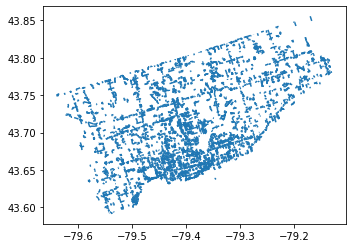

In [70]:
join_6.plot()

In [71]:
#filling in NA values
#join_6.total_count.fillna('N/A',inplace=True)

# Joining Traffic Cameras

In [72]:
traffic_cameras.head()

,camera_number,traffic_cameras_latitude,traffic_cameras_longitude,traffic_cameras_main_road,traffic_cameras_traffic_cameras,geometry
0,Camera8000,43.64945,-79.371464,ABELL ST,Yes,POINT (43.649 -79.371)
1,Camera8001,43.643120,-79.381386,YORK ST,Yes,POINT (43.643 -79.381)
2,Camera8002,43.64222,-79.384068,LOWER SIMCOE ST,Yes,POINT (43.642 -79.384)
3,Camera8003,43.649461,-79.371267,JARVIS ST,Yes,POINT (43.649 -79.371)
4,Camera8004,43.645153,-79.382574,UNIVERSITY AVE,Yes,POINT (43.645 -79.383)


In [73]:
#processing traffic cameras dataframe

#setting camera number as index
traffic_cameras.set_index('camera_number',inplace=True)

#dropping latitude and longitude columns
#traffic_cameras = traffic_cameras.drop(columns=['traffic_cameras_latitude','traffic_cameras_longitude'])

#renaming columns
traffic_cameras.rename(columns={'traffic_cameras_traffic_cameras':'traffic_cameras_present'},inplace=True)

#setting CRS to EPSG:4326
traffic_cameras = traffic_cameras.to_crs('EPSG:4326')


In [74]:
#processing geometry column

#replacing the geometry column
traffic_cameras = traffic_cameras.drop(columns=['geometry'])

traffic_cameras['geometry'] = gpd.points_from_xy(traffic_cameras['traffic_cameras_longitude'],traffic_cameras['traffic_cameras_latitude'],crs='EPSG:4326')

#converting to geodataframe
traffic_cameras = gpd.GeoDataFrame(traffic_cameras,geometry=traffic_cameras['geometry'])

In [75]:
traffic_cameras.head(1)

,traffic_cameras_latitude,traffic_cameras_longitude,traffic_cameras_main_road,traffic_cameras_present,geometry
camera_number,,,,,
Camera8000,43.64945,-79.371464,ABELL ST,Yes,POINT (-79.37146 43.64945)


In [ ]:
#spatial join on traffic cameras
join_7 = join_6.sjoin_nearest(traffic_cameras,how='left',lsuffix='road_network',rsuffix='traffic_cameras',max_distance=0.0003)

In [77]:
join_7.shape

(10875, 31)

In [78]:
join_7.head(2)

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name,road_class,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,index_traffic_cameras,traffic_cameras_latitude,traffic_cameras_longitude,traffic_cameras_main_road,traffic_cameras_present
centreline_id,,,,,,,,,,,,,,,,,,,,,
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,NaN,NaN,NaN,NaN,NaN
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,TWENTY FIRST ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,NaN,NaN,NaN,NaN,NaN


In [79]:
#dropping unneccesary columns
join_7 = join_7.drop(columns=['index_traffic_cameras','traffic_cameras_latitude','traffic_cameras_longitude','traffic_cameras_main_road'])

In [80]:
#filling N/A values where traffic camera is not present
join_7.traffic_cameras_present.fillna('No',inplace=True)

In [81]:
join_7.traffic_cameras_present.value_counts()

No     10078
Yes      797
Name: traffic_cameras_present, dtype: int64

<AxesSubplot:>

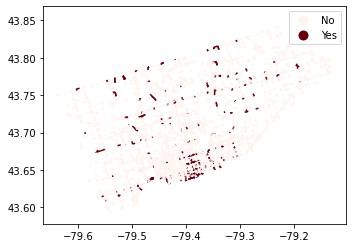

In [82]:
join_7.plot(column='traffic_cameras_present',legend=True,cmap='Reds')

<AxesSubplot:>

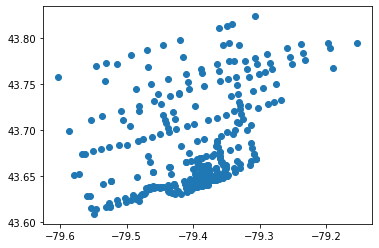

In [83]:
traffic_cameras.plot()

# Joining Speed Limits

In [84]:
speed_limits.head()

,road_name,road_class,speed_limit,geometry
0,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46436 43.68254, -79.46542 43.6..."
1,ROGERS RD,Minor Arterial,40,"LINESTRING (-79.46328 43.68278, -79.46436 43.6..."
2,ROSETHORN AVE,Local,50,"LINESTRING (-79.46375 43.68108, -79.46436 43.6..."
3,SILVERTHORN AVE,Collector,50,"LINESTRING (-79.46267 43.68132, -79.46328 43.6..."
4,BLACKTHORN AVE,Local,40,"LINESTRING (-79.46183 43.68211, -79.46216 43.6..."


In [85]:
#joining speed limit dataframe
join_8 = join_7.sjoin(speed_limits,how='inner',lsuffix='road_network',rsuffix='speed_limits')

In [86]:
join_8.shape

(12693, 31)

In [87]:
join_7.shape

(10875, 27)

In [88]:
speed_limits.shape

(58956, 4)

In [89]:
join_8.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name_road_network,road_class_road_network,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,index_speed_limits,road_name_speed_limits,road_class_speed_limits,speed_limit
centreline_id,,,,,,,,,,,,,,,,,,,,,
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,No,49505,TWENTIETH ST,Local,30
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,TWENTY FIRST ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,No,49503,TWENTY FIRST ST,Local,30
914588,Twentieth Street,St,201500,Local,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",Yes,BIRMINGHAM ST,Collector,2,Yes,...,7573,90.423881,9.456716,0.119403,1.456716,No,580,BIRMINGHAM ST,Collector,50
9950476,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.54180 43.59258, -79.5421...",Yes,BROWNS LI LAKESHORE W RAMP,Major Arterial Ramp,2,No,...,12341,92.684942,7.217424,0.097634,2.538490,No,44187,BROWNS LI LAKESHORE W RAMP,Major Arterial Ramp,50
3135620,Brown's Line,Line,201200,Major Arterial,"MULTILINESTRING ((-79.54291 43.59652, -79.5432...",No,OWEN DR,Local,2,No,...,12426,99.098812,0.542308,0.358880,4.378340,No,9164,OWEN DR,Local,50


In [90]:
#dropping unneccesary columns
join_8 = join_8.drop(columns=['index_speed_limits'])

<AxesSubplot:>

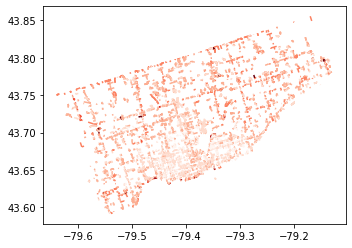

In [91]:
join_8.plot(column='speed_limit',cmap='Reds')

# Joining Sensitive Zones

In [92]:
sensitive_zones.head()

,sensitive_zone_name,sensitive_zone_type,sensitive_zone_latitude,sensitive_zone_longitude,sensitive_zone_sensitive_zone,geometry
0,"CENTENNIAL COLLEGE, ASHTONBEE CAMPUS",Education,43.73070998,-79.28978994,Yes,POINT (43.73071 -79.28979)
1,"CENTENNIAL COLLEGE, CARLAW CAMPUS",Education,43.68465985,-79.34886383,Yes,POINT (43.68466 -79.34886)
2,"CENTENNIAL COLLEGE, MIDLAND CAMPUS",Education,43.7523045,-79.26565895,Yes,POINT (43.75230 -79.26566)
3,"CENTENNIAL COLLEGE, MORNINGSIDE CAMPUS",Education,43.78660651,-79.19292513,Yes,POINT (43.78661 -79.19293)
4,"CENTENNIAL COLLEGE, PROGRESS CAMPUS",Education,43.78527327,-79.22702962,Yes,POINT (43.78527 -79.22703)


In [93]:
#processing geometry column


#replacing the geometry column
sensitive_zones = sensitive_zones.drop(columns=['geometry'])

sensitive_zones['geometry'] = gpd.points_from_xy(sensitive_zones['sensitive_zone_longitude'],sensitive_zones['sensitive_zone_latitude'],crs='EPSG:4326')

#converting to geodataframe
sensitive_zones = gpd.GeoDataFrame(sensitive_zones,geometry=sensitive_zones['geometry'])

#restricting sensitive zones to toronto boundaries
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.y<44]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.y>43.5]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.x<-79]
sensitive_zones = sensitive_zones.loc[sensitive_zones.geometry.x>-79.9]

In [94]:
sensitive_zones.head()

,sensitive_zone_name,sensitive_zone_type,sensitive_zone_latitude,sensitive_zone_longitude,sensitive_zone_sensitive_zone,geometry
0,"CENTENNIAL COLLEGE, ASHTONBEE CAMPUS",Education,43.73070998,-79.28978994,Yes,POINT (-79.28979 43.73071)
1,"CENTENNIAL COLLEGE, CARLAW CAMPUS",Education,43.68465985,-79.34886383,Yes,POINT (-79.34886 43.68466)
2,"CENTENNIAL COLLEGE, MIDLAND CAMPUS",Education,43.7523045,-79.26565895,Yes,POINT (-79.26566 43.75230)
3,"CENTENNIAL COLLEGE, MORNINGSIDE CAMPUS",Education,43.78660651,-79.19292513,Yes,POINT (-79.19293 43.78661)
4,"CENTENNIAL COLLEGE, PROGRESS CAMPUS",Education,43.78527327,-79.22702962,Yes,POINT (-79.22703 43.78527)


In [ ]:
#joining sensitive zones dataframe with radius search of 100 metres
join_9 = join_8.sjoin_nearest(sensitive_zones,how='left',lsuffix='road_network',rsuffix='sensitive_zones',max_distance=0.001)

In [96]:
join_9.shape

(13979, 36)

In [97]:
#dropping unneccesary columns
join_9 = join_9.drop(columns=['index_sensitive_zones','sensitive_zone_name','sensitive_zone_latitude','sensitive_zone_longitude','sensitive_zone_type'])

In [98]:
#filling N/A values where sensitive zone is not present
join_9.sensitive_zone_sensitive_zone.fillna('No',inplace=True)

<AxesSubplot:>

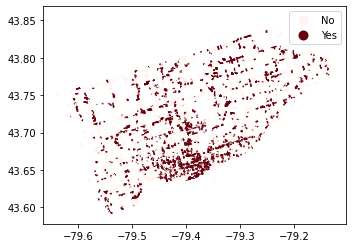

In [99]:
join_9.plot(column='sensitive_zone_sensitive_zone',legend=True,cmap='Reds')

<AxesSubplot:>

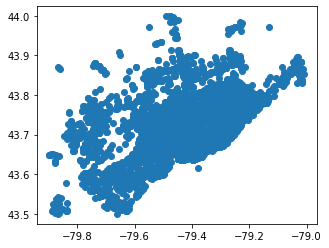

In [100]:
sensitive_zones.plot()

In [101]:
join_9.head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name_road_network,road_class_road_network,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,road_name_speed_limits,road_class_speed_limits,speed_limit,sensitive_zone_sensitive_zone
centreline_id,,,,,,,,,,,,,,,,,,,,,
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,No,TWENTIETH ST,Local,30,Yes
914587,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,TWENTIETH ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,No,TWENTIETH ST,Local,30,Yes
6735911,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,TWENTY FIRST ST,Local,2,No,...,7573,90.423881,9.456716,0.119403,1.456716,No,TWENTY FIRST ST,Local,30,Yes
914588,Twentieth Street,St,201500,Local,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",Yes,BIRMINGHAM ST,Collector,2,Yes,...,7573,90.423881,9.456716,0.119403,1.456716,No,BIRMINGHAM ST,Collector,50,Yes
9950476,Lake Shore Boulevard West,Blvd,201200,Major Arterial,"MULTILINESTRING ((-79.54180 43.59258, -79.5421...",Yes,BROWNS LI LAKESHORE W RAMP,Major Arterial Ramp,2,No,...,12341,92.684942,7.217424,0.097634,2.538490,No,BROWNS LI LAKESHORE W RAMP,Major Arterial Ramp,50,No


<AxesSubplot:>

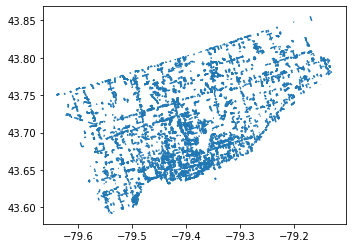

In [102]:
join_9.plot()

In [103]:
join_9.shape

(13979, 31)

# Joining Collisions

In [104]:
collisions.head()

,eventuniqueid,collisions_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_division,collisions_neighbourhood,collisions_fatalities,collisions_injury_collisions,collisions_ftr_collisions,collisions_pd_collisions,collisions_longitude,collisions_latitude,collisions_fatal_collisions,collisions_time_of_day,geometry
0,GO-20168000055,January,Friday,2016,16,D42,LAmoreaux (117),0,NO,NO,YES,-79.319271,43.795851,NO,afternoon,POINT (-79.31927 43.79585)
1,GO-20168000056,January,Friday,2016,17,D54/D55,Woodbine Corridor (64),0,YES,NO,NO,-79.320851,43.683944,NO,evening,POINT (-79.32085 43.68394)
2,GO-20168000057,January,Friday,2016,19,D41,Kennedy Park (124),0,NO,YES,NO,-79.251653,43.732248,NO,evening,POINT (-79.25165 43.73225)
3,GO-20168000058,January,Friday,2016,3,D52,Bay Street Corridor (76),0,NO,NO,YES,-79.385522,43.646053,NO,night,POINT (-79.38552 43.64605)
4,GO-20168000059,January,Friday,2016,4,D41,Birchcliffe-Cliffside (122),0,NO,NO,YES,-79.284020,43.680810,NO,night,POINT (-79.28402 43.68081)


In [105]:
collisions_pivot = pd.pivot_table(collisions,values='eventuniqueid',index=['geometry'],aggfunc='count')

In [106]:
collisions.geometry.duplicated().sum()

342035

In [107]:
collisions_pivot.head()

,eventuniqueid
geometry,
POINT (-79.86157 43.53445),1
POINT (-79.87038 43.54254),1
POINT (-79.87656 43.53352),1
POINT (-79.88843 43.52648),1
POINT (-79.79518 43.44924),1


In [108]:
collisions_pivot = gpd.GeoDataFrame(collisions_pivot,geometry=collisions_pivot.index.values,crs='EPSG:4326')

In [109]:
collisions_pivot.head()

,eventuniqueid,geometry
geometry,,
POINT (-79.86157 43.53445),1,POINT (-79.86157 43.53445)
POINT (-79.87038 43.54254),1,POINT (-79.87038 43.54254)
POINT (-79.87656 43.53352),1,POINT (-79.87656 43.53352)
POINT (-79.88843 43.52648),1,POINT (-79.88843 43.52648)
POINT (-79.79518 43.44924),1,POINT (-79.79518 43.44924)


<AxesSubplot:>

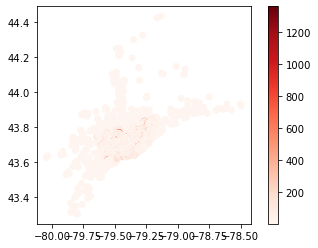

In [110]:
collisions_pivot.plot(column='eventuniqueid',legend=True,cmap='Reds')

In [111]:
collisions_pivot.head()

,eventuniqueid,geometry
geometry,,
POINT (-79.86157 43.53445),1,POINT (-79.86157 43.53445)
POINT (-79.87038 43.54254),1,POINT (-79.87038 43.54254)
POINT (-79.87656 43.53352),1,POINT (-79.87656 43.53352)
POINT (-79.88843 43.52648),1,POINT (-79.88843 43.52648)
POINT (-79.79518 43.44924),1,POINT (-79.79518 43.44924)


In [112]:
collisions_pivot.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
join_10 = join_9.sjoin_nearest(collisions_pivot,how='left',lsuffix='road_network',rsuffix='collisions',max_distance=0.0003)

In [114]:
join_10.shape

(13979, 33)

In [115]:
join_10.tail(2)

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name_road_network,road_class_road_network,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,road_name_speed_limits,road_class_speed_limits,speed_limit,sensitive_zone_sensitive_zone,index_collisions,eventuniqueid
centreline_id,,,,,,,,,,,,,,,,,,,,,
9796840,Lawrence Avenue West,Ave,201200,Major Arterial,"MULTILINESTRING ((-79.49881 43.70390, -79.5000...",No,BLACKSTONE ST,Local,2,No,...,3.491322,0.710444,9.824419,No,BLACKSTONE ST,Local,40,Yes,POINT (-79.50001 43.70362),15.0
446528,Duckworth Street,St,201500,Local,"MULTILINESTRING ((-79.49959 43.70210, -79.4996...",No,LAWRENCE AVE W,Major Arterial,4,No,...,3.491322,0.710444,9.824419,No,LAWRENCE AVE W,Major Arterial,50,Yes,POINT (-79.49955 43.70210),3.0


<AxesSubplot:>

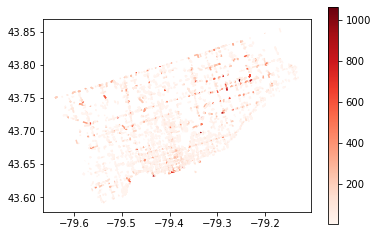

In [116]:
join_10.plot(column='eventuniqueid',legend=True,cmap='Reds')

<AxesSubplot:>

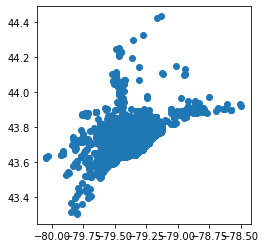

In [117]:
collisions.plot()

In [118]:
#filling in NA values
join_10.eventuniqueid.fillna(0,inplace=True)

In [119]:
#dropping unneccesary columns
join_10 = join_10.drop(columns=['index_collisions'])
#renaming columns
join_10.rename(columns={'eventuniqueid':'collisions_count'},inplace=True)

In [120]:
join_10.sort_values('collisions_count',ascending=False).head()

,linear_name_full_legal,linear_name_type,feature_code,feature_code_desc,geometry,bikelane_present,road_name_road_network,road_class_road_network,number_of_lanes,pedestrian_crossover_pedestrian_crossover,...,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,road_name_speed_limits,road_class_speed_limits,speed_limit,sensitive_zone_sensitive_zone,collisions_count
centreline_id,,,,,,,,,,,,,,,,,,,,,
107462,Progress Avenue,Ave,201300,Minor Arterial,"MULTILINESTRING ((-79.25422 43.77665, -79.2540...",No,BOROUGH DR,Major Arterial Ramp,4,No,...,98.877416,1.111994,0.01059,2.779984,No,PLANNING BOUNDARY,Geostatistical line,40,No,1064.0
107426,McCowan Rd S Progress Ave Ramp,Ramp,201201,Major Arterial Ramp,"MULTILINESTRING ((-79.25422 43.77665, -79.2539...",No,PROGRESS AVE,Minor Arterial,4,No,...,98.877416,1.111994,0.01059,2.779984,No,PROGRESS AVE,Minor Arterial,50,No,1064.0
107462,Progress Avenue,Ave,201300,Minor Arterial,"MULTILINESTRING ((-79.25422 43.77665, -79.2540...",No,PROGRESS AVE,Minor Arterial,4,No,...,98.877416,1.111994,0.01059,2.779984,No,PROGRESS AVE,Minor Arterial,50,No,1064.0
107462,Progress Avenue,Ave,201300,Minor Arterial,"MULTILINESTRING ((-79.25422 43.77665, -79.2540...",No,PROGRESS AVE,Minor Arterial,4,No,...,98.877416,1.111994,0.01059,2.779984,No,PLANNING BOUNDARY,Geostatistical line,40,No,1064.0
107462,Progress Avenue,Ave,201300,Minor Arterial,"MULTILINESTRING ((-79.25422 43.77665, -79.2540...",No,PROGRESS AVE,Minor Arterial,4,No,...,98.877416,1.111994,0.01059,2.779984,No,PLANNING BOUNDARY,Geostatistical line,40,No,1064.0


# Joining KSI

In [121]:
ksi.head()

,index,ksi_year,ksi_date,ksi_time,ksi_street1,ksi_street2,ksi_road_class,ksi_district,ksi_latitude,ksi_longitude,...,ksi_speeding,ksi_ag_driv,ksi_redlight,ksi_alcohol,ksi_disability,ksi_neighbourhood_158,ksi_division,geometry,ksi_intersection,ksi_time_of_day
0,80566288,2016,2016-08-01,2,MORNINGSIDE AVE,HALFWAY AVE,Minor Arterial,Scarborough,43.817847,-79.213687,...,NaN,Yes,NaN,NaN,NaN,Malvern East,D42,POINT (-79.213687 43.817847),"MORNINGSIDE AVE,HALFWAY AVE",night
1,80632072,2016,2016-08-02,18,FRONT ST E,YONGE ST,Major Arterial,Toronto and East York,43.646811,-79.376933,...,NaN,Yes,NaN,NaN,NaN,St Lawrence-East Bayfront-The Islands,D51,POINT (-79.376933 43.646811),"FRONT ST E,YONGE ST",evening
2,80632073,2016,2016-08-02,18,FRONT ST E,YONGE ST,Major Arterial,Toronto and East York,43.646811,-79.376933,...,NaN,Yes,NaN,NaN,NaN,St Lawrence-East Bayfront-The Islands,D51,POINT (-79.376933 43.646811),"FRONT ST E,YONGE ST",evening
3,80632074,2016,2016-08-02,21,BLUE JAYS WAY,NAVY WHARF CRT,Minor Arterial,Toronto and East York,43.641570,-79.391864,...,NaN,Yes,NaN,NaN,NaN,Harbourfront-CityPlace,D52,POINT (-79.391864 43.64157),"BLUE JAYS WAY,NAVY WHARF CRT",night
4,80632075,2016,2016-08-02,21,BLUE JAYS WAY,NAVY WHARF CRT,Minor Arterial,Toronto and East York,43.641570,-79.391864,...,NaN,Yes,NaN,NaN,NaN,Harbourfront-CityPlace,D52,POINT (-79.391864 43.64157),"BLUE JAYS WAY,NAVY WHARF CRT",night


In [122]:
#dropping geometry column from ksi dataframe
ksi = ksi.drop(columns=['geometry'])
#creating new geometry column
ksi['geometry'] = gpd.points_from_xy(ksi['ksi_longitude'],ksi['ksi_latitude'],crs='EPSG:4326')

In [123]:
#creating pivot table of KSI collisions
ksi_pivot = pd.pivot_table(ksi,values='index',index=['geometry'],aggfunc='count')

In [124]:
ksi_pivot.sort_values('index',ascending=False)

,index
geometry,
POINT (-79.48641 43.74470),19
POINT (-79.43888 43.66843),15
POINT (-79.38581 43.66074),15
POINT (-79.51142 43.68389),14
POINT (-79.49446 43.78151),13
...,...
POINT (-79.31112 43.75873),1
POINT (-79.35632 43.66657),1
POINT (-79.51471 43.71109),1


In [125]:
#collisions_pivot = gpd.GeoDataFrame(collisions_pivot,geometry=collisions_pivot.index.values,crs='EPSG:4326')

In [126]:
#converting to geodataframe
ksi_pivot = gpd.GeoDataFrame(ksi_pivot,geometry=ksi_pivot.index.values,crs='EPSG:4326')

In [127]:
ksi_pivot.head()

,index,geometry
geometry,,
POINT (-79.59541 43.65376),1,POINT (-79.59541 43.65376)
POINT (-79.58171 43.65053),1,POINT (-79.58171 43.65053)
POINT (-79.58049 43.65372),2,POINT (-79.58049 43.65372)
POINT (-79.58118 43.65089),2,POINT (-79.58118 43.65089)
POINT (-79.57946 43.65134),2,POINT (-79.57946 43.65134)


In [128]:
#renaming columns
ksi_pivot.rename(columns={'index':'ksi_count'},inplace=True)

<AxesSubplot:>

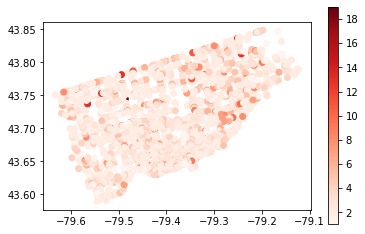

In [129]:
ksi_pivot.plot(column='ksi_count',legend=True,cmap='Reds')

In [130]:
ksi.shape

(5962, 49)

In [131]:
join_10.shape

(13979, 32)

In [132]:
join_11 = join_10.sjoin_nearest(ksi_pivot,how='left',lsuffix='road_network',rsuffix='ksi',max_distance=0.0003)

/Users/rakeenahmed/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [133]:
#filling in NA values
join_11.ksi_count.fillna(0,inplace=True)

<AxesSubplot:>

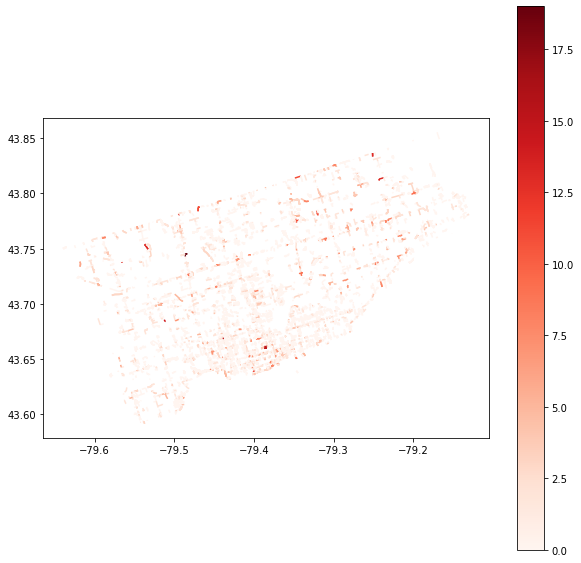

In [134]:
join_11.plot(column='ksi_count',legend=True,cmap='Reds',figsize=(10,10))

<AxesSubplot:>

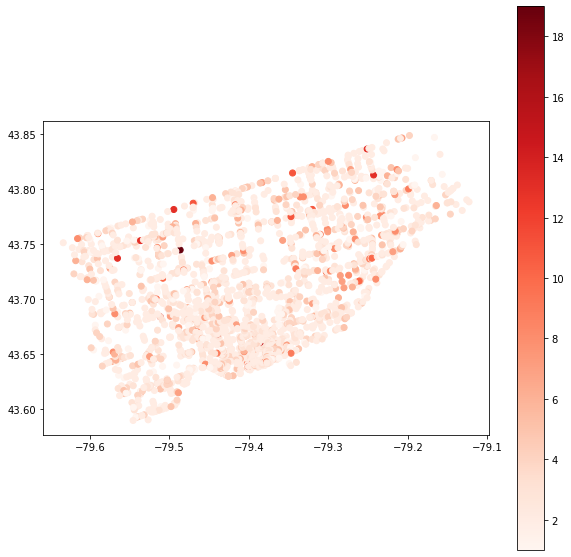

In [135]:
ksi_pivot.plot(column='ksi_count',legend=True,cmap='Reds',figsize=(10,10))

In [136]:
#dropping unnecesary columns
join_11 = join_11.drop(columns=['index_ksi'])

In [137]:
join_11.shape

(13979, 33)

# Exporting Final Data Frame

In [138]:
#setting new name for final dataframe
final_df = join_11

In [139]:
#final processing

#dropping uneecessary columns
final_df = final_df.drop(columns=['feature_code','road_name_road_network','road_class_road_network','index_traffic_volumes','location','road_name_speed_limits','road_class_speed_limits','index_speed_enforcement'])

#renaming columns
final_df = final_df.rename(columns={'linear_name_full_legal':'road_name','linear_name_type':'road_hierarchy','feature_code_desc':'road_classification','pedestrian_crossover_pedestrian_crossover':'pedestrian_crossover_present','traffic_calmingspeed_hump':'speed_hump_count','traffic_calmingtraffic_island':'traffic_island_count','traffic_calmingspeed_cushion':'speed_cushion_count','sensitive_zone_sensitive_zone':'sensitive_zone'})

In [140]:
final_df.head()

,road_name,road_hierarchy,road_classification,geometry,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_hump_count,traffic_island_count,speed_cushion_count,...,vehicle_count,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,ksi_count
centreline_id,,,,,,,,,,,,,,,,,,,,,
914587,Lake Shore Boulevard West,Blvd,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,2,No,0.0,0.0,0.0,...,7573,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0
914587,Lake Shore Boulevard West,Blvd,Major Arterial,"MULTILINESTRING ((-79.51805 43.59795, -79.5191...",No,2,No,0.0,0.0,0.0,...,7573,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0
6735911,Lake Shore Boulevard West,Blvd,Major Arterial,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",No,2,No,0.0,0.0,0.0,...,7573,90.423881,9.456716,0.119403,1.456716,No,30,Yes,24.0,2.0
914588,Twentieth Street,St,Local,"MULTILINESTRING ((-79.51914 43.59770, -79.5202...",Yes,2,Yes,0.0,0.0,0.0,...,7573,90.423881,9.456716,0.119403,1.456716,No,50,Yes,1.0,0.0
9950476,Lake Shore Boulevard West,Blvd,Major Arterial,"MULTILINESTRING ((-79.54180 43.59258, -79.5421...",Yes,2,No,0.0,0.0,0.0,...,12341,92.684942,7.217424,0.097634,2.538490,No,50,No,76.0,1.0


In [141]:
#exporting dataframe
final_df.to_csv('/Users/rakeenahmed/Library/CloudStorage/GoogleDrive-rakeenaahmed@gmail.com/My Drive/Centennial/BA 723 - Business Analytics Capstone/Projects/Toronto KSI/Modeling/final_df.csv')
final_df.to_file('/Users/rakeenahmed/Library/CloudStorage/GoogleDrive-rakeenaahmed@gmail.com/My Drive/Centennial/BA 723 - Business Analytics Capstone/Projects/Toronto KSI/Modeling/final_df.geojson',driver='GeoJSON')